In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)


<module 'epri_mc_lib_2' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [53]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Import data and merge replicates

In [62]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data.csv'),
                    index_col=None)
#merged.index = merged.index.str.rstrip('-12345')
#mean_df = merged.groupby('ID').mean()
# Get rid of cold work
#cw_regex = re.compile("[0-9]+$") 
#mean_df['cold_work'] = [int(re.search(cw_regex,x).group()) for x in mean_df.index]
#mean_df.index = mean_df.index.str.rstrip('02468')
#mean_df.index = mean_df.index.str.rstrip('-')
merged.set_index('type_cw', inplace=True)
merged

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS,Type
type_cw,,,,,,,,,,,,,,,
A286-80,60.489458,0.010580,0.002000,0.002000,-1.409903,0.046787,0.002109,3.640283e+02,0.025513,2.594648,184.875799,0.018969,1.705626,-62.977927,A286
A286-80,44.261992,0.013681,0.002000,0.002000,-1.508575,0.046089,0.001903,4.615413e+02,0.022798,1.890054,901.546526,0.022046,1.504480,-64.434818,A286
A286-0,156.352240,0.014511,0.002000,0.002000,-1.220520,0.045382,0.002143,9.688812e-13,0.008521,3.973307,47.009106,0.002548,1.640369,-0.455673,A286
304-80,70.025254,4.788344,2.131362,2.820919,-1.055187,0.067237,0.002424,8.023317e+01,0.027521,3.165900,158.586692,0.024863,3.235830,-8.051534,304
304-40,102.089063,1.070462,0.821760,1.754141,-1.201403,0.052497,0.001934,4.029531e+01,0.022566,2.870203,637.420387,0.012983,5.242440,-36.263322,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347-40,96.533556,0.338549,0.179534,0.225540,-1.261545,0.056277,0.002174,1.350067e+02,0.006515,1.112177,238.429845,0.023679,1.824403,-36.890105,347
A286-20,71.566934,0.009250,0.002000,0.002000,-1.150631,0.044825,0.002063,6.842860e+02,0.022014,1.675595,1292.052416,0.011407,0.373688,-28.171811,A286
304-80,81.170931,3.926854,2.239491,3.551210,-0.930937,0.067434,0.002443,8.748498e+01,0.023465,3.085555,139.648195,0.018672,2.814763,2.662860,304


In [63]:
merged=merged[merged.index.isin(['304-0','304-20','304-40','304-60','304-80'])]

In [64]:
merged

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS,Type
type_cw,,,,,,,,,,,,,,,
304-80,70.025254,4.788344,2.131362,2.820919,-1.055187,0.067237,0.002424,8.023317e+01,0.027521,3.165900,158.586692,0.024863,3.235830,-8.051534,304
304-40,102.089063,1.070462,0.821760,1.754141,-1.201403,0.052497,0.001934,4.029531e+01,0.022566,2.870203,637.420387,0.012983,5.242440,-36.263322,304
304-0,165.235029,0.807079,0.251327,0.374528,-1.464704,0.050231,0.002681,1.182266e-09,0.014438,3.107483,4.728826,0.005717,1.467994,10.241568,304
304-0,133.232115,0.079517,0.106150,0.575568,-1.497238,0.047187,0.002660,1.576046e-09,0.016390,2.752073,52.180646,0.005351,1.402917,-11.373612,304
304-0,138.155633,0.026303,0.028601,0.010504,-1.663164,0.048397,0.002580,1.573671e-09,0.019787,2.617819,-9.786436,0.005483,1.140755,-23.798033,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304-60,85.191779,1.867292,1.223026,1.985375,-1.251053,0.053134,0.002712,8.145334e+01,0.008589,0.974730,167.972940,0.014472,2.116972,-31.374450,304
304-20,85.213854,0.664860,0.497527,0.416898,-1.246710,0.070860,0.002057,7.517958e+01,0.021191,1.881288,86.955713,0.007633,1.224667,-30.566351,304
304-0,121.052310,0.430705,0.032981,0.268871,-1.576753,0.048919,0.002688,1.756160e-06,0.018446,3.406455,-4.107478,0.006638,1.357113,1.425212,304


## Select columns of interest

In [65]:
#mean_df = mean_df[mc.regression_cols].dropna()

In [66]:
#mean_df.index=mean_df.index+"-"+mean_df.cold_work.astype("str")

In [67]:
#mean_df.drop(["cold_work"], axis=1, inplace=True)
merged.drop(["Type"], axis=1, inplace=True)

/home/nick/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
#mean_df=mean_df.iloc[10:15]
#mean_df

## Scale data

In [69]:
merged.KJIC = np.log(merged.KJIC)
scaled_df = mc.scale_general(merged, MinMaxScaler())
scaled_df[0]

/home/nick/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS
type_cw,,,,,,,,,,,,,,
304-80,0.221430,0.877665,0.664721,0.511953,0.735784,0.218530,0.636290,4.573336e-01,0.942504,0.591307,0.329261,0.719427,0.394150,0.533928
304-40,0.530986,0.192443,0.253099,0.317626,0.565531,0.064603,0.168295,2.296855e-01,0.733799,0.522271,1.000000,0.325521,0.697623,0.036378
304-0,0.926377,0.143901,0.073806,0.066312,0.258945,0.040930,0.880349,6.723999e-12,0.391523,0.577668,0.113741,0.084591,0.126789,0.856550
304-0,0.749608,0.009808,0.028176,0.102934,0.221063,0.009143,0.861057,8.968567e-12,0.473726,0.494691,0.180210,0.072446,0.116947,0.475339
304-0,0.779405,0.000000,0.003801,0.000000,0.027859,0.021777,0.784682,8.955031e-12,0.616785,0.463347,0.093408,0.076841,0.077298,0.256219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304-60,0.382411,0.339302,0.379221,0.359748,0.507718,0.071253,0.910759,4.642886e-01,0.145188,0.079737,0.342409,0.374903,0.224938,0.122599
304-20,0.382623,0.117689,0.151189,0.074030,0.512775,0.256366,0.286261,4.285278e-01,0.675887,0.291390,0.228922,0.148118,0.089989,0.136851
304-0,0.670887,0.074533,0.005178,0.047065,0.128476,0.027230,0.887840,1.001020e-08,0.560299,0.647469,0.101363,0.115119,0.110019,0.701062


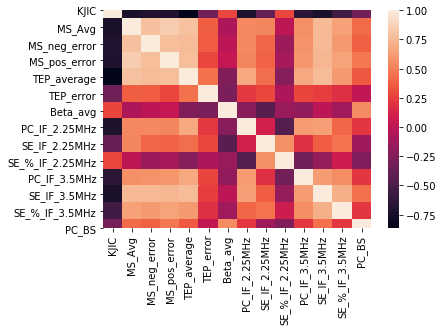

In [70]:
sns.heatmap(merged.corr())

In [71]:
# Creating Predictor variable 'X' and Target Variable 'y'

# X contains all the features except for the target value Price
X = scaled_df[0].drop('KJIC', axis = 1)
y = scaled_df[0]['KJIC']

In [72]:
X

,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS
type_cw,,,,,,,,,,,,,
304-80,0.877665,0.664721,0.511953,0.735784,0.218530,0.636290,4.573336e-01,0.942504,0.591307,0.329261,0.719427,0.394150,0.533928
304-40,0.192443,0.253099,0.317626,0.565531,0.064603,0.168295,2.296855e-01,0.733799,0.522271,1.000000,0.325521,0.697623,0.036378
304-0,0.143901,0.073806,0.066312,0.258945,0.040930,0.880349,6.723999e-12,0.391523,0.577668,0.113741,0.084591,0.126789,0.856550
304-0,0.009808,0.028176,0.102934,0.221063,0.009143,0.861057,8.968567e-12,0.473726,0.494691,0.180210,0.072446,0.116947,0.475339
304-0,0.000000,0.003801,0.000000,0.027859,0.021777,0.784682,8.955031e-12,0.616785,0.463347,0.093408,0.076841,0.077298,0.256219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
304-60,0.339302,0.379221,0.359748,0.507718,0.071253,0.910759,4.642886e-01,0.145188,0.079737,0.342409,0.374903,0.224938,0.122599
304-20,0.117689,0.151189,0.074030,0.512775,0.256366,0.286261,4.285278e-01,0.675887,0.291390,0.228922,0.148118,0.089989,0.136851
304-0,0.074533,0.005178,0.047065,0.128476,0.027230,0.887840,1.001020e-08,0.560299,0.647469,0.101363,0.115119,0.110019,0.701062


In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)

# X_train contains 70% of total dataset
print(y_train.shape)
# X_test contains 30% of total dataset
print(X_test.shape)

(186,)
(81, 13)


## Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression

In [76]:
lr = LinearRegression()

In [77]:
#Train/fit the model to training data
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
# print the intercept
print(lr.intercept_)

#Coefficients
coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
coeff_df

0.7734462108447486


,Coefficient
MS_Avg,-0.062887
MS_neg_error,-0.032068
MS_pos_error,-0.071501
TEP_average,-0.392508
TEP_error,0.163886
Beta_avg,0.142345
PC_IF_2.25MHz,-0.095582
SE_IF_2.25MHz,-0.124591
SE_%_IF_2.25MHz,0.178084
PC_IF_3.5MHz,-0.374446


In [79]:
pred = lr.predict(X_test)

Text(0, 0.5, 'Predicted Fracture Toughness')

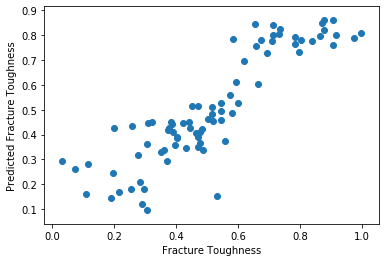

In [80]:
plt.scatter(y_test,pred)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [81]:
from sklearn import metrics

In [82]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.084410727231875
MSE: 0.01172095409668612
RMSE: 0.10826335528093575


## Lasso

In [83]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [84]:
print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)

Lasso Regression: R^2 score on training set 0.0
Lasso Regression: R^2 score on test set -3.7575413424249193


In [85]:
# Lasso with different lambdas
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [86]:
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

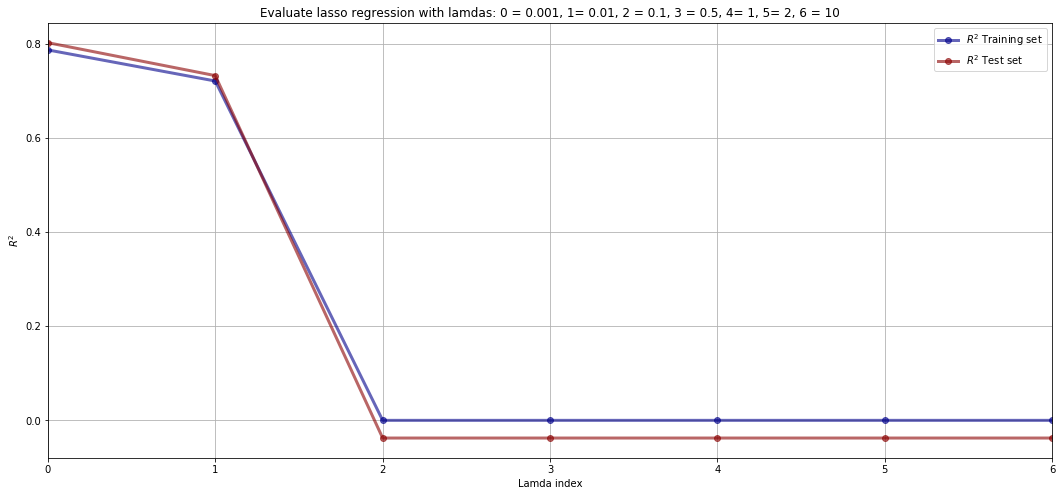

In [87]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [88]:
# Identifying the best lambda
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    80.237227
lambda        0.001000
Name: 0, dtype: float64

In [89]:
# Coefficients of best model
reg_best = Lasso(alpha = 0.001)
reg_best.fit(X_train, y_train)
reg_best.coef_

array([-8.53517947e-02, -8.11571354e-03, -3.89277689e-02, -5.17348667e-01,
        5.11221437e-02,  9.30582916e-02, -1.46038086e-01, -2.69484302e-05,
        6.86814812e-02, -0.00000000e+00, -9.31459556e-02, -0.00000000e+00,
       -3.59814111e-03])

In [90]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg_best.predict(X_test))

0.010023477752478839

In [91]:
# Cross Validation
l_min = 0.05
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

In [92]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=5, scoring="r2") 

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

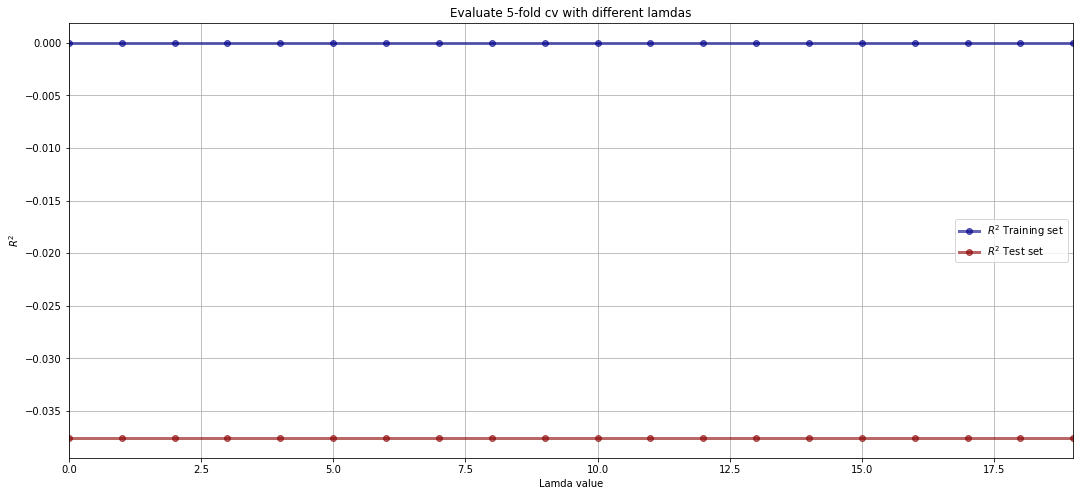

In [93]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

In [94]:
# Best Model
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared   -3.757541
lambda       0.050000
Name: 0, dtype: float64

In [95]:
# Best Model
reg_best = Lasso(alpha = 0.05)
reg_best.fit(X_train, y_train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [96]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, reg_best.predict(X_test))

0.05262477252459681

In [97]:
reg_best.coef_

array([-0., -0., -0., -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0.])

Text(0, 0.5, 'Predicted Fracture Toughness')

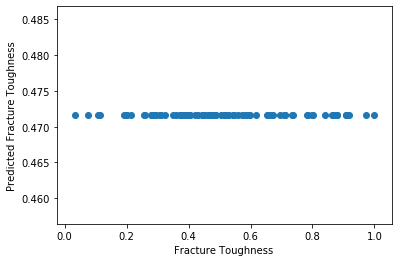

In [98]:
pred1 = reg_best.predict(X_test)
plt.scatter(y_test,pred1)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [99]:
pred1

array([0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161696,
       0.47161696, 0.47161696, 0.47161696, 0.47161696, 0.47161

## Ridge Regression

In [100]:
# Ridge Regression
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.09837674661267481
0.8004432140788911
0.10787712736480563
0.7705499340169748


Text(0, 0.5, 'Predicted Fracture Toughness')

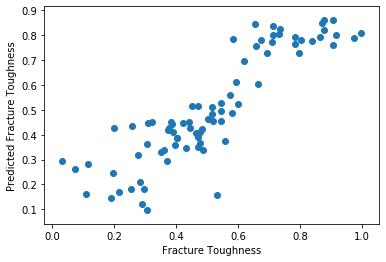

In [101]:
plt.scatter(y_test,pred_test_rr)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

## Elastic net

In [102]:
#Elastic Net
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

0.10936369409378624
0.7533802056185173
0.10772250850652014
0.7712071981381926


Text(0, 0.5, 'Predicted Fracture Toughness')

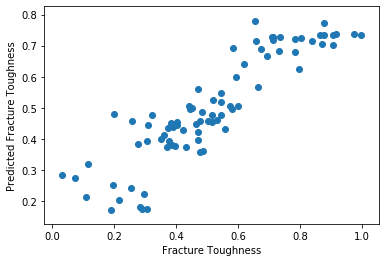

In [103]:
plt.scatter(y_test,pred_test_enet)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

### Lasso - 2

In [104]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

0.11633716865606195
0.7209265197104824
0.11650001759483283
0.732402887786249


Text(0, 0.5, 'Predicted Fracture Toughness')

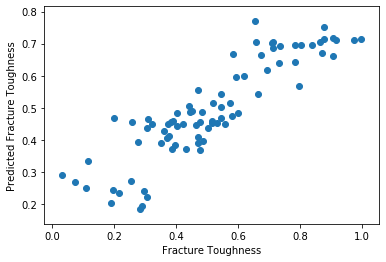

In [105]:
plt.scatter(y_test,pred_test_lasso)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")